In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size, hidden_size, num_layers,num_classes):
    super(RNN,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    
    #Elman Rnn
    self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                      num_layers = num_layers, batch_first = True, bias = True)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size , num_classes)

  def forward(self,x):
    #x.size(0) => batch_Size
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out,_ = self.rnn(x,h_0)
    out = self.fc(out[:][-1][:])
    return out

In [ ]:
class LSTM(nn.Module):
  def __init__(self,input_size, hidden_size, num_layers,num_classes):
    super(RNN,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    
    #Long short term dependency
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                      num_layers = num_layers, batch_first = True, bias = True)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size , num_classes)

  def forward(self,x):
    #x.size(0) => batch_Size
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    out,(hn, cn) = self.lstm(x,h_0)
    out = self.fc(out[:][-1][:])
    return out

In [ ]:
daily_train = pd.read_csv("./Daily-train.csv")
daily_test = pd.read_csv("./Daily-test.csv")

In [ ]:
daily_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
daily_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Columns: 9920 entries, V1 to V9920
dtypes: float64(9919), object(1)
memory usage: 125.7+ MB


In [ ]:
d_train = daily_train.dropna(axis = 1)
d_test = daily_test.dropna(axis = 1)

In [ ]:
#index 제거
d_train = d_train.drop(['V1'], axis = 'columns')
d_test = d_test.drop(['V1'], axis = 'columns')

In [ ]:
#hyperparameter
window_size = 5
hidden_size = 64
num_classes = 1
num_layers = 1

lr = 0.001
num_epochs = 1000

In [ ]:
#data scaling
scaler = MinMaxScaler()
scaler.fit(d_train)
scaler2 = MinMaxScaler()
scaler2.fit(d_test)

d_train_scaled = scaler.transform(d_train)
d_test_scaled = scaler2.transform(d_test)

d_train_list = d_train_scaled[0]
d_test_list = d_test_scaled[0]


X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(d_train_list)- window_size -1):
  X_train.append(d_train_list[i:i+window_size])
  y_train.append(d_train_list[i+window_size])


for i in range(len(d_test_list) - window_size - 1):
  X_test.append(d_test_list[i:i+window_size])  
  y_test.append(d_test_list[i+window_size])

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print("train/test shape : ",X_train.shape, X_test.shape)

train/test shape :  torch.Size([91, 5]) torch.Size([8, 5])


In [ ]:
#reshape
#input ( batch_size, sequence, input)
#output( batch_size)
X_train = X_train.view(1,-1,window_size)
X_test = X_test.view(1,-1,window_size)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)

print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape :  torch.Size([1, 91, 5])
y_train shape :  torch.Size([91])
X_test shape : torch.Size([1, 8, 5])
y_test shape : torch.Size([8])


In [ ]:
model = RNN(window_size,hidden_size, num_layers, num_classes)
optimizer = optim.Adam(model.parameters(), lr = lr)
critertion = torch.nn.MSELoss()

In [ ]:
for epoch in range(num_epochs+1):
  output = model.forward(X_train)
  optimizer.zero_grad()
  loss = critertion(output, y_train)
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print("Epoch : ", epoch, "loss :",  loss.item())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([91])) that is different to the input size (torch.Size([91, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch :  0 loss : 0.006469827610999346
Epoch :  100 loss : 4.8155423428397626e-05
Epoch :  200 loss : 2.895981197070796e-05
Epoch :  300 loss : 2.8616050258278847e-05
Epoch :  400 loss : 2.8603108148672618e-05
Epoch :  500 loss : 2.859373671526555e-05
Epoch :  600 loss : 2.8585796826519072e-05
Epoch :  700 loss : 2.8578959245351143e-05
Epoch :  800 loss : 2.8573056624736637e-05
Epoch :  900 loss : 2.8567901608766988e-05
Epoch :  1000 loss : 2.8563330488395877e-05


In [ ]:
y_pred = model(X_test)

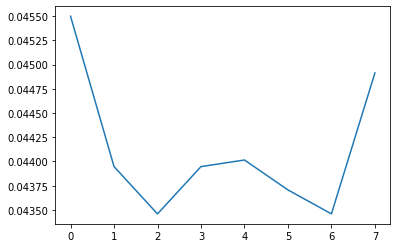

In [ ]:
y_pred_numpy = y_pred.detach().numpy()
y_test_numpy = y_test.numpy()
plt.plot(range(len(y_pred_numpy)),y_pred_numpy)
plt.show()